# Package instalation

In [1]:
!pip install BayesClassifiers

Defaulting to user installation because normal site-packages is not writeable


# Bayes Classifiers analysis with covariance ellipsoid

Automatically created module for IPython interactive environment


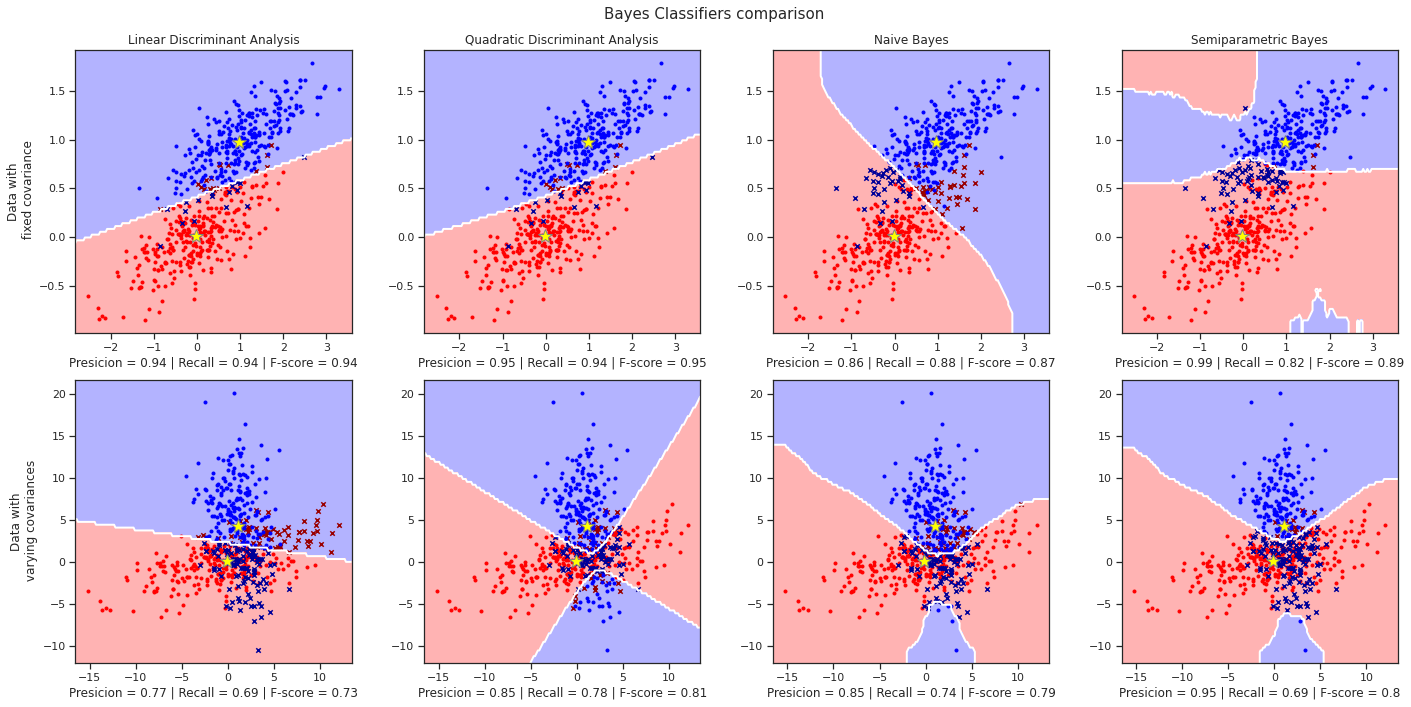

In [52]:
print(__doc__)

from scipy import linalg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from keras.utils import to_categorical

import BayesClassifiers as BC

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(classifier, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 4, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant')
    elif fig_index == 3:
        plt.title('Naive Bayes')
    elif fig_index == 4:
        plt.title('Semiparametric Bayes')
    elif fig_index == 5:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]
    Precision = len(X0_tp) / (len(X0_fp) + len(X0_tp)) 
    Recall = len(X0_tp) / (len(X1_fp) + len(X0_tp)) 
    F_score = (2 * Precision * Recall) / (Precision + Recall)
    
    plt.xlabel(f"Presicion = {round(Precision, 2)} | Recall = {round(Recall, 2)} | F-score = {round(F_score, 2)}")

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['var1', 'var2'])
    Z = classifier.predict(data)
    Z = to_categorical(Z)
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(np.mean(X0[:, 0]), np.mean(X0[:, 1]),
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(np.mean(X1[:, 0]), np.mean(X1[:, 1]),
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return splot


plt.figure(figsize=(20, 10), facecolor='white')
plt.suptitle('Bayes Classifiers comparison',
             y=0.98, fontsize=15)
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    data_X = pd.DataFrame(X, columns=['var1', 'var2'])
    data_y = pd.DataFrame(y, columns=['training_class'])
    
    lda = BC.BayesClassifier(descr_is_linear = True)
    lda.fit(data_X, data_y)
    y_pred = lda.predict(data_X)
    splot = plot_data(lda, X, y, y_pred, fig_index=4 * i + 1)
    plt.axis('tight')
    
    qda = BC.BayesClassifier(descr_is_linear = False)
    qda.fit(data_X, data_y)
    y_pred = qda.predict(data_X)
    splot = plot_data(qda, X, y, y_pred, fig_index=4 * i + 2)
    plt.axis('tight')
    
    nb = BC.NaiveBayesClassifier(kernel = 'exponential')
    nb.fit(data_X, data_y)
    y_pred = nb.predict(data_X)
    splot = plot_data(nb, X, y, y_pred, fig_index=4 * i + 3)
    plt.axis('tight')
    
    sb = BC.SemiparametricBayesClassifier(kernel = 'exponential')
    sb.fit(data_X, data_y)
    y_pred = sb.predict(data_X)
    splot = plot_data(sb, X, y, y_pred, fig_index=4 * i + 4)
    plt.axis('tight')
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Results on iris data

In [62]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

data_X = pd.DataFrame(X, columns=['sepal_length', 'sepal_width', 'pental_length', 'pental_width'])
data_y = pd.DataFrame(y, columns=['training_class'])

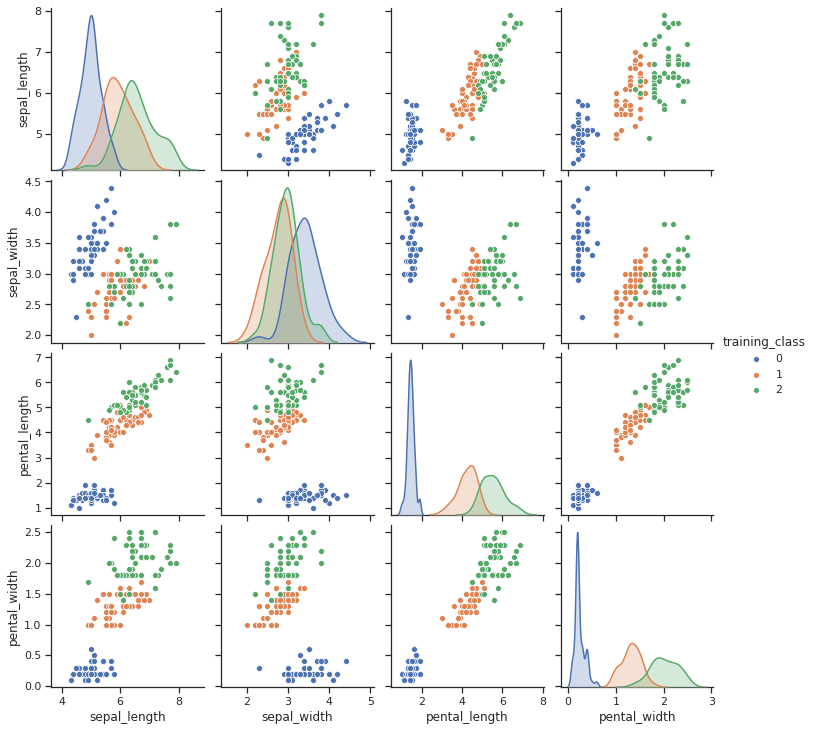

In [63]:
import seaborn as sns 

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(pd.concat([data_X, data_y], axis = 1), hue = 'training_class')

In [69]:
lda = BC.BayesClassifier(descr_is_linear = True)
lda.fit(data_X, data_y)
y_pred = lda.predict(data_X)
print(f"Linear Discriminant accuracy: {round(sum(data_y['training_class'].values == y_pred)/len(y), 4)}\n")

qda = BC.BayesClassifier(descr_is_linear = False)
qda.fit(data_X, data_y)
y_pred = qda.predict(data_X)
print(f"Quadratic Discriminant accuracy: {round(sum(data_y['training_class'].values == y_pred)/len(y), 4)}\n")

nb = BC.NaiveBayesClassifier(kernel = 'linear')
nb.fit(data_X, data_y)
y_pred = nb.predict(data_X)
print(f"Naive Bayes accuracy: {round(sum(data_y['training_class'].values == y_pred)/len(y), 4)}\n")

sb = BC.SemiparametricBayesClassifier(kernel = 'linear')
sb.fit(data_X, data_y)
y_pred = sb.predict(data_X)
print(f"Semiparametric Bayes accuracy: {round(sum(data_y['training_class'].values == y_pred)/len(y), 4)}\n")

Linear Discriminant accuracy: 0.98

Quadratic Discriminant accuracy: 0.98

Naive Bayes accuracy: 0.9467

Semiparametric Bayes accuracy: 0.8467

